In [1]:
import os
import sys
import json
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.nn import functional as F
from opts import parse_opts
from model import generate_model
from mean import get_mean, get_std
from spatial_transforms import (
    Compose, Normalize, Scale, CenterCrop, CornerCrop, MultiScaleCornerCrop,
    MultiScaleRandomCrop, RandomHorizontalFlip, ToTensor)
from temporal_transforms import LoopPadding, TemporalRandomCrop, TemporalBeginCrop
from target_transforms import ClassLabel, VideoID
from target_transforms import Compose as TargetCompose
from dataset import get_training_set, get_validation_set, get_test_set
from utils import Logger
from train import train_epoch
from validation import val_epoch
import test
from datasets.moments import Moments
from models import resnet, pre_act_resnet, wide_resnet, resnext, densenet
from scipy.misc import imresize as imresize
import cv2
from PIL import Image
from torch.utils.data import Dataset
import glob
import torchvision.transforms as trn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


import torchvision.models as models
import time

In [2]:
rootPath = "./data"   ## subject to change
resultPath = os.path.join(rootPath, 'results')

In [3]:
def buildIndexLabelMapping() :
    idx2label = os.listdir(os.path.join(rootPath, 'Moments_in_Time_Mini/jpg/validation'))
    label2idx = {}
    for i, label in enumerate(idx2label) :
        label2idx[label] = i
    return idx2label, label2idx

idx2label, label2idx = buildIndexLabelMapping()

In [4]:
class Moments(Dataset) :
    """
    A customized data loader for Moments-In-Time dataset.
    """    
    def __init__(self, subset='validation', use_frames=16) :
        super().__init__()
        root = os.path.join(rootPath, 'Moments_in_Time_Mini/jpg', subset)     
        self.use_frames = use_frames
        
        self.filenames = []

        for video_path in glob.glob(os.path.join(root, "*/*")) :
            label = video_path.split('/')[-2]
            self.filenames.append((video_path, label2idx[label]))
        self.len = len(self.filenames)
        
        self.tf = trn.Compose([trn.Resize((224, 224)), 
                               trn.ToTensor()
                              ])
        
    def __getitem__(self, index) :
        video_path, label = self.filenames[index]
        tot_frames = len(os.listdir(video_path)) - 1
        video = []
        time_spacing = (tot_frames-1)//(self.use_frames-1)
        for i in range(1, 1+self.use_frames * time_spacing, time_spacing) :
            img = Image.open(os.path.join(video_path, 'image_{:05d}.jpg'.format(i))).convert('RGB')
            video.append(self.tf(img))
        return torch.stack(video, dim=1), label, video_path.split('/')[-1]

    def __len__(self) :
        return self.len

In [5]:
debug = False
valset = Moments(subset='validation')
print("Number of validation videos:", len(valset))

Number of validation videos: 10000


In [6]:
class FrameResNet50(nn.Module) :
    def __init__(self, use_pretrain=-1, num_classes=200) :
        super().__init__()
        self.frame_model = models.resnet50(num_classes=num_classes) ## back to 50
        if (use_pretrain >= 0) :
            self.loadPretrainedParam(use_pretrain)
        
    def forward(self, x) :
        B, C, T, H, W = x.shape
        if self.training :
            return self.frame_model(x[:,:,T//2,:,:])
        else :
            logits = self.frame_model(x.permute(0, 2, 1, 3, 4).contiguous().view(-1, C, H, W))
            return logits.view(B, T, -1).mean(dim=1)
    
    def loadPretrainedParam(self, n_levels) :
        assert(n_levels <= 4)
        resnet_imgnet_checkpoint = torch.load(os.path.join(rootPath, 'models/resnet50-19c8e357.pth'))
        # resnet_imgnet_checkpoint = torch.load(os.path.join(rootPath, 'models/resnet18-5c106cde.pth'))  ## back to 50
        states_to_load = {}
        for name, param in resnet_imgnet_checkpoint.items() :
            if name.startswith('fc') :
                continue
            if name.startswith('layer') :
                if int(name[5]) <= n_levels :
                    states_to_load[name]=param
            else :
                states_to_load[name]=param
        model_state = self.frame_model.state_dict()
        model_state.update(states_to_load)
        self.frame_model.load_state_dict(model_state)

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [8]:
def load_frame_model(model_name) :
        frame_model_checkpoint = torch.load(model_name)
        frame_model = models.resnet50(num_classes=200)
        frame_model.load_state_dict(frame_model_checkpoint)
        return frame_model


model_name = './data/results/fm-2d_resnet-3.pth'
model = load_frame_model(model_name)

In [9]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [10]:
def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))

In [11]:
model.layer4.register_forward_hook(hook_feature)
model.avgpool.register_forward_hook(hook_feature)

In [12]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(imresize(cam_img, size_upsample))
    return output_cam

In [13]:
params = list(model.parameters())
weight_softmax = params[-2].cpu().data.numpy()
weight_softmax[weight_softmax<0] = 0

In [89]:
video_num = 9999

In [90]:
for frame in range(16):
    features_blobs = []
    
    logit = model.forward(valset.__getitem__(video_num)[0][:,frame,:,:].unsqueeze(0))
    h_x = F.softmax(logit, 1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    idx = idx.cpu().data.numpy()
    
    CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])
    
    img = valset.__getitem__(video_num)[0][:,frame,:,:].transpose(0,1).transpose(1,2).cpu().data.numpy()*255
    
    height, width, _ = img.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    result = (heatmap * 0.4 + img * 0.5)

    file_name_result = './data/CAM/'+idx2label[valset.__getitem__(video_num)[1]]+'_'+ valset.__getitem__(video_num)[2]+'_'+str(video_num)+'_'+str(frame)+'.jpg'
    cv2.imwrite(file_name_result, result)

/home/jasonzy/anaconda3/envs/cs231n/lib/python3.6/site-packages/ipykernel/__main__.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


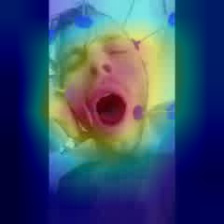

In [91]:
result_pic = Image.open(file_name_result)
result_pic

In [92]:
print('Ground Truth:')
print(idx2label[valset.__getitem__(video_num)[1]])

Ground Truth:
yawning


In [93]:
print('--Top Actions:')
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], idx2label[idx[i]]))

--Top Actions:
0.046 -> sweeping
0.033 -> scratching
0.033 -> camping
0.023 -> playing+music
0.022 -> drumming
